In [1]:
!hostname

c0800a-s35.ufhpc


In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [160]:
f_bkg_model = '/cmsuf/data/store/user/ekoenig/root/cmseos.fnal.gov/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/JetHT_Data_UL/bkg_model_ntuple.root'
f_signal = '/cmsuf/data/store/user/ekoenig/root/cmseos.fnal.gov/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8/asr_ntuple.root'
f_signal = '/cmsuf/data/store/user/ekoenig/root/cmseos.fnal.gov/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-850_MY-700_TuneCP5_13TeV-madgraph-pythia8/asr_ntuple.root'
f_signal = '/cmsuf/data/store/user/ekoenig/root/cmseos.fnal.gov/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-450_MY-300_TuneCP5_13TeV-madgraph-pythia8/asr_ntuple.root'

In [174]:
signal = ObjIter([Tree([f_signal], weights=['scale'], normalization=None, xsec=1)])
signal.scale.npy.sum()

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


0.0019886037872890714

In [161]:
bkg_model = ObjIter([Tree([f_bkg_model], weights=['scale'], normalization=None, is_model=True, sample='bkg model', color='lavender')])

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


In [162]:
(signal + bkg_model).apply(lambda t : t.extend(kfold=np.arange(len(t)) % 2))

[None, None]

In [163]:

def xyh_from_3h(h_p4, assignment):
    assignment = ak.from_regular(assignment)

    h_p4 = h_p4[assignment]

    hx_p4 = h_p4[:,0]

    hy_p4 = h_p4[:,1:]
    hy_p4 = hy_p4[ ak.argsort(-hy_p4.pt, axis=1) ]

    h1_p4 = hy_p4[:,0]
    h2_p4 = hy_p4[:,1]

    y_p4 = h1_p4 + h2_p4
    x_p4 = hx_p4 + y_p4

    kins = ['pt','m','eta','phi']
    return dict(
        **{ f'X_{field}': getattr(x_p4, field) for field in kins },
        **{ f'Y_{field}': getattr(y_p4, field) for field in kins },
        **{ f'H1_{field}': getattr(h1_p4, field) for field in kins+['signalId'] },
        **{ f'H2_{field}': getattr(h2_p4, field) for field in kins+['signalId'] },
        **{ f'HX_{field}': getattr(hx_p4, field) for field in kins+['signalId'] },
    )

In [164]:
f_model = '/home/ekoenig/analysis/weaver-multiH/models/feynnet_lightning.parametric/X_YH_3H_6b/xyh/lightning_logs/version_1'

import utils.weaverUtils as weaver

k0_model = weaver.WeaverONNX(f_model, onnxdir='onnx', k=0)
k1_model = weaver.WeaverONNX(f_model, onnxdir='onnx', k=1)

In [165]:
gen_X_m = signal[0].mx
gen_Y_m = signal[0].my

In [166]:
def predict_tree(tree, model):
    features = get_collection(tree, 'h')
    features['h_sinphi'] = np.sin(features['h_phi'])
    features['h_cosphi'] = np.cos(features['h_phi'])
    features['gen_X_m'] = np.ones(len(tree)) * gen_X_m
    features['gen_Y_m'] = np.ones(len(tree)) * gen_Y_m

    results = model.predict(features)
    h_p4 = build_p4(features, 'h', extra=['signalId'])
    return xyh_from_3h(h_p4, results['sorted_h_assignments'])

In [167]:
sig_weights = signal.scale.cat
sig_y_ms = [ signal.apply(lambda t : predict_tree(t, model)['Y_m']).cat for model in [k0_model, k1_model] ]
sig_index = signal.kfold.cat

bkg_weights = bkg_model.scale.cat
bkg_y_ms = [ bkg_model.apply(lambda t : predict_tree(t, model)['Y_m']).cat for model in [k0_model, k1_model] ]
bkg_index = bkg_model.kfold.cat

predicting: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


In [168]:
varinfo.Y_m = dict(bins=(0,1500,31))
varinfo.X_m = dict(bins=(375,1500,31))

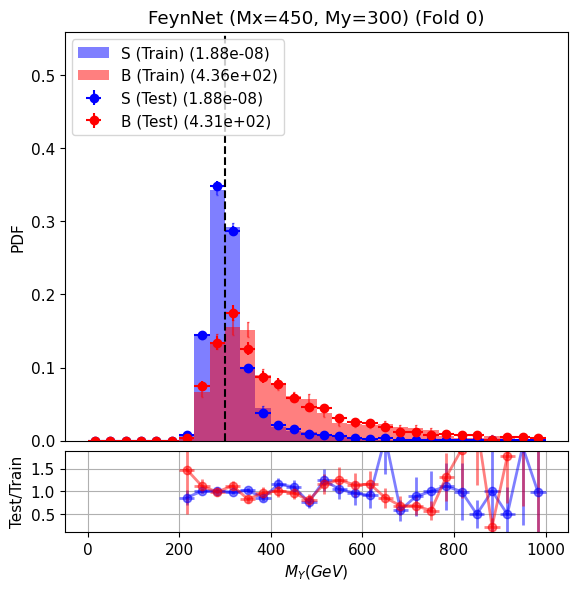

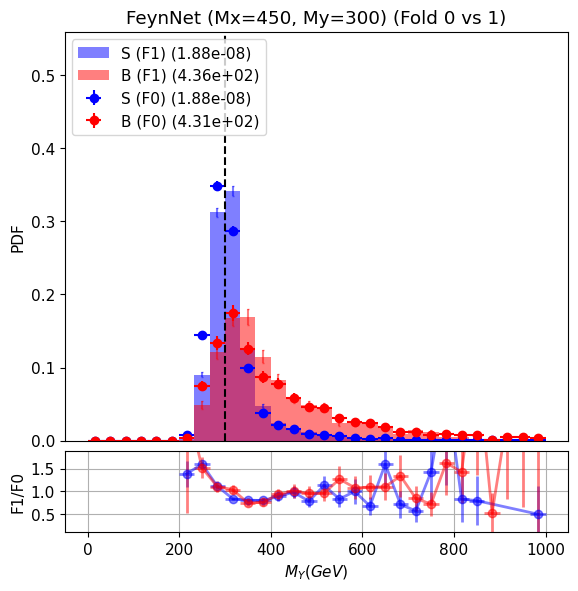

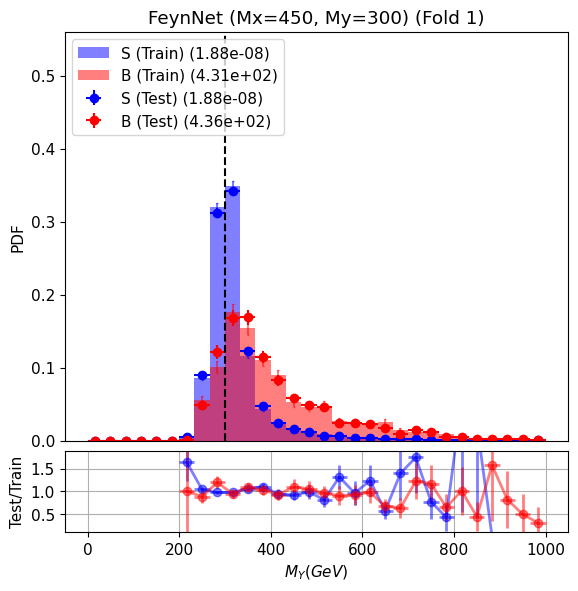

In [170]:
kfolds = 2 

for i in range(kfolds):
        # trained discriminant in train/test samples
            fig, ax, _ = hist_multi(
                [sig_y_ms[i][sig_index != i], bkg_y_ms[i][bkg_index != i], sig_y_ms[i][sig_index == i], bkg_y_ms[i][bkg_index == i]],
                weights = [sig_weights[sig_index != i], bkg_weights[bkg_index != i], sig_weights[sig_index == i], bkg_weights[bkg_index == i]],
                bins=(0,1000,31,), stacked=False,
                title=f'FeynNet (Mx={gen_X_m}, My={gen_Y_m}) (Fold {i})',
                xlabel='$M_{Y} (GeV)$',
                is_data = [False, False, True, True],
                h_label=['S (Train)', 'B (Train)', 'S (Test)', 'B (Test)'],
                h_color=['blue', 'red', 'blue', 'red'],
                h_alpha=[0.5, 0.5, 1.0, 1.0],
                h_histtype=['stepfilled', 'stepfilled', None, None],
                efficiency=True, legend=True,

                ratio=True, r_group=((0, 2), (1, 3)), r_ylabel='Test/Train',
            )

            ax.plot([gen_Y_m, gen_Y_m], [0, 1], color='black', linestyle='--', label='Truth')

            for j in range(i + 1, kfolds):
                fig, ax, _ = hist_multi(
                    [sig_y_ms[j][sig_index == j], bkg_y_ms[j][bkg_index == j], sig_y_ms[i][sig_index == i], bkg_y_ms[i][bkg_index == i]],
                    weights = [sig_weights[sig_index == j], bkg_weights[bkg_index == j], sig_weights[sig_index == i], bkg_weights[bkg_index == i]],
                    bins=(0,1000,31,), stacked=False,
                    is_data = [False, False, True, True],
                    title=f'FeynNet (Mx={gen_X_m}, My={gen_Y_m}) (Fold {i} vs {j})',
                    xlabel='$M_{Y} (GeV)$',
                    h_label=[f'S (F{j})', f'B (F{j})', f'S (F{i})', f'B (F{i})'],
                    h_color=['blue', 'red', 'blue', 'red'],
                    h_alpha=[0.5, 0.5, 1.0, 1.0],
                    h_histtype=['stepfilled', 'stepfilled', None, None],
                    efficiency=True, legend=True,

                    ratio=True, r_group=((0, 2), (1, 3)), r_ylabel=f'F{j}/F{i}',
                )
                ax.plot([gen_Y_m, gen_Y_m], [0, 1], color='black', linestyle='--', label='Truth')


100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


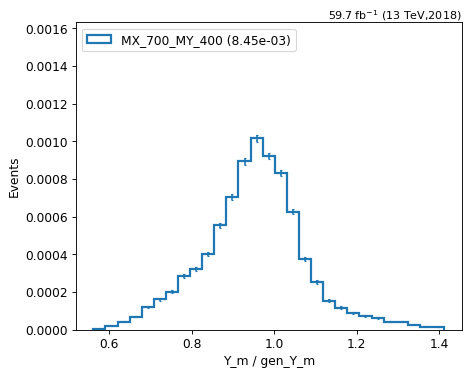